In [1]:
import numpy as np
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, shiftgrid
import matplotlib.pyplot as plt
import os
import pygrib
from copy import deepcopy
import datetime

In [2]:
os.environ['CFLAGS']='-I/usr/local/lib/python2.7/dist-packages/numpy/core/include'

In [3]:
from meteo import wmap

## Analyse wrf

In [4]:
#WRF Data
wrf=Dataset('/mnt/poseidon/INGRID/WRF/wrfout_1nest_15km/all.nc')

In [5]:
# Grab these variables for now
temps =  wrf.variables['T2']
u_wind_ms = wrf.variables['U10']
v_wind_ms = wrf.variables['V10']
psfc = wrf.variables['PSFC']
T = wrf.variables['T']
times = wrf.variables['Times']

In [6]:
# x_dim and y_dim are the x and y dimensions of the model
# domain in gridpoints
x_dim = len(wrf.dimensions['west_east'])
y_dim = len(wrf.dimensions['south_north'])

# Get the grid spacing
dx = float(wrf.DX)
dy = float(wrf.DY)

width_meters = dx * (x_dim - 1)
height_meters = dy * (y_dim - 1)

cen_lat = float(wrf.CEN_LAT)
cen_lon = float(wrf.CEN_LON)
truelat1 = float(wrf.TRUELAT1)
truelat2 = float(wrf.TRUELAT2)
standlon = float(wrf.STAND_LON)
#truelat1 = float(60)
#truelat2 = float(10)



In [7]:
# Draw the base map behind it with the lats and
# lons calculated earlier
m = Basemap(resolution='i',projection='lcc',\
    width=width_meters,height=height_meters,\
    lat_0=cen_lat,lon_0=cen_lon,lat_1=truelat1,\
    lat_2=truelat2)


In [8]:
minlon=wrf.variables['XLONG'][0].min()-1
maxlon=wrf.variables['XLONG'][0].max()+1
minlat=wrf.variables['XLAT'][0].min()-1
maxlat=wrf.variables['XLAT'][0].max()+1


In [9]:
minlon,maxlon,minlat,maxlat

(-101.11001586914062,
 -88.889999389648438,
 13.889999389648438,
 26.110000610351562)

In [10]:
# define parallels and meridians to draw.
parallels = np.arange(-90.,90,5.)
meridians = np.arange(0.,360.,5.)


In [11]:
m = Basemap(projection='cyl',llcrnrlat=minlat,urcrnrlat=maxlat,\
             llcrnrlon=minlon,urcrnrlon=maxlon,resolution='h')


In [12]:
time=132
print ''.join(times[time])

2013-09-15_12:00:00


In [13]:
# This sets the standard grid point structure at full resolution
x,y = m(wrf.variables['XLONG'][0],wrf.variables['XLAT'][0])


In [14]:
# Thin factor is used for thinning out wind barbs
thin = 5

In [15]:
# This sets a thinn-ed out grid point structure for plotting
# wind barbs at the interval specified in "thin"
x_th,y_th = m(wrf.variables['XLONG'][0,::thin,::thin],\
        wrf.variables['XLAT'][0,::thin,::thin])


In [16]:
# Convert Surface Pressure to Mean Sea Level Pressure
stemps = temps[time]+6.5*wrf.variables['HGT'][time]/1000.
mslp = wrf.variables['PSFC'][time]*np.exp(9.81/(287.0*stemps)*wrf.variables['HGT'][time])*0.01 + (6.7 * wrf.variables['HGT'][time] / 1000)

In [17]:
# Set universal figure margins
width = 10
height = 8


In [18]:
plt.ioff()
plt.figure(figsize=(width,height))
plt.rc("figure.subplot", left = .001)
plt.rc("figure.subplot", right = .999)
plt.rc("figure.subplot", bottom = .001)
plt.rc("figure.subplot", top = .999)

plt.ion()

In [19]:
# Convert winds from m/s to kts and then draw barbs
u_wind_kts = u_wind_ms[time] * 1.94384449
v_wind_kts = v_wind_ms[time] * 1.94384449

/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


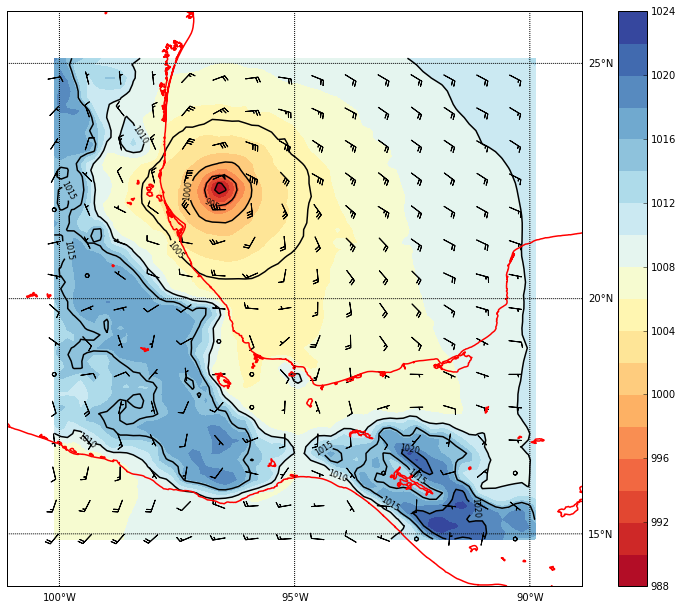

In [20]:
plt.figure(figsize=(width,height),frameon=False)
# Contour the pressure
Pf=m.contourf(x,y,mslp,20,cmap=plt.cm.RdYlBu)

P=m.contour(x,y,mslp,V=2,colors='k',linewidths=1.5)
plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

m.barbs(x_th,y_th,u_wind_kts[::thin,::thin],\
                v_wind_kts[::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5,color='r')
m.drawparallels(parallels,labels=[False,True,True,False])
m.drawmeridians(meridians,labels=[True,False,False,True])

plt.colorbar(Pf)
plt.title = 'Sfc Temp, MSLP (mb), 10m Wind (kts)'
plt.show()

## Analyse ECMWF Oper

In [21]:
date=datetime.datetime.strptime(''.join(times[time]),'%Y-%m-%d_%H:%M:%S')

In [22]:
date

datetime.datetime(2013, 9, 15, 12, 0)

In [23]:
yyyy=date.year # this is for facilitating the folder format below
mm=date.month
dd=date.day
hh=date.hour

In [24]:
path='/mnt/poseidon/INGRID/OPER/WDIRA/{:04d}/{:02d}/{:02d}/'.format(yyyy,mm,dd)

In [25]:
filename=path+'{:04d}{:02d}{:02d}.{:02d}.{}.grib'.format(yyyy,mm,dd,hh,'tropical_cyclone')
nt=12
p2,u2,v2,y2,x2 = wmap(filename,0,3*(nt+1),minlon,maxlon,minlat,maxlat)

100%|██████████| 39/39 [00:18<00:00,  1.78it/s]      | 1/39 [00:00<00:37,  1.01it/s]


meteo done


In [26]:
thin=5

In [27]:
x2_th,y2_th=x2[::thin,::thin],y2[::thin,::thin]

In [28]:
u2_wind_kts, v2_wind_kts=u2[0]* 1.94384449, v2[0]* 1.94384449

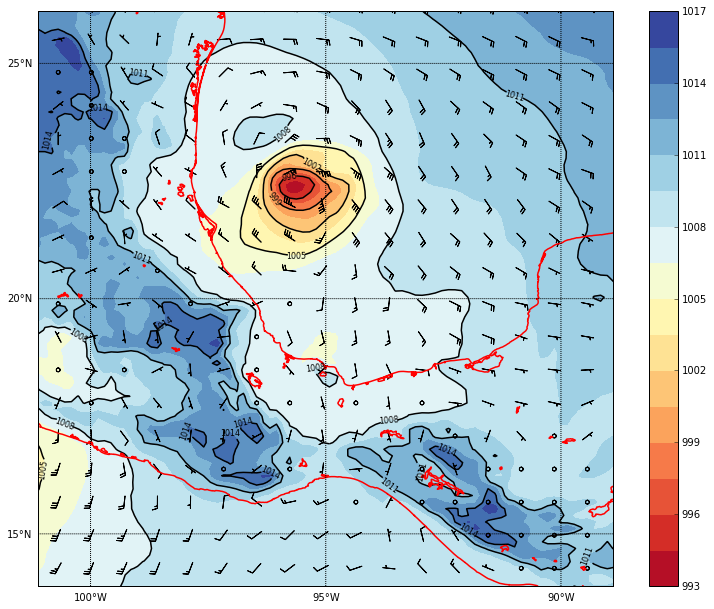

In [29]:
plt.figure(figsize=(width,height),frameon=False)
# Contour the pressure
Pf=m.contourf(x2,y2,p2[0,:,:],20,cmap=plt.cm.RdYlBu)

P=m.contour(x2,y2,p2[0,:,:],V=2,colors='k',linewidths=1.5)
plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

m.barbs(x2_th,y2_th,u2_wind_kts[::thin,::thin],\
                v2_wind_kts[::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5,color='r')
m.drawparallels(parallels,labels=[1,0,0,0])
m.drawmeridians(meridians,labels=[0,0,0,1])


plt.colorbar(Pf)
plt.title = 'Sfc Temp, MSLP (mb), 10m Wind (kts)'
plt.show()

## Analyse ERAI

In [30]:
path='/mnt/poseidon/INGRID/ERAI/'

In [31]:
initd=datetime.datetime(2013,9,10,0)

In [32]:
dt=(date-initd).total_seconds()/3600.

In [33]:
filename=path+'ERAI_SFC_INGRID_20130910_0000_{}.grib'.format(int(dt))

In [34]:
erai=pygrib.open(filename)

In [35]:
for k in erai[:]:
    print k

1:Geopotential:m**2 s**-2 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
2:10 metre U wind component:m s**-1 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
3:10 metre V wind component:m s**-1 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
4:2 metre temperature:K (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
5:2 metre dewpoint temperature:K (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
6:Land-sea mask:(0 - 1) (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
7:Surface pressure:Pa (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
8:Mean sea level pressure:Pa (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
9:Skin temperature:K (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
10:Sea-ice cover:(0 - 1) (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 201309151200
11:Sea surface

In [36]:
pp,uu,vv=erai[8],erai[2],erai[3]

In [37]:
lats,lons=pp.latlons()

In [38]:
def shiftmap(varin):

    zlon=varin.shape[1]
    varin_ = np.hstack([varin[:,zlon/2:],varin[:,0:zlon/2]])
    svarin  = varin_
    return svarin
    
def erai_parser(filename,minlon,maxlon,minlat,maxlat):
    erai=pygrib.open(filename)
    pp,uu,vv=erai[8].data()[0],erai[2].data()[0],erai[3].data()[0]
    ilat,ilon=erai[8].latlons()

    lon=ilon[0,:]
    lat=np.flipud(ilat)[:,0]

    pp=pp*.01 #convert tp hPa
    
    if minlon < 0. :
        lon=lon-180.
 
    pp=shiftmap(pp)
    uu=shiftmap(uu)
    vv=shiftmap(vv)
    i1=np.abs(lon-minlon).argmin()-2
    i2=np.abs(lon-maxlon).argmin()+2
    j1=np.abs(lat-minlat).argmin()-2
    j2=np.abs(lat-maxlat).argmin()+2
    
    pp=np.flipud(pp)
    uu=np.flipud(uu)
    vv=np.flipud(vv)

    lons, lats = np.meshgrid(lon[i1:i2],lat[j1:j2])
    p=deepcopy(pp[j1:j2,i1:i2])   
    u=deepcopy(uu[j1:j2,i1:i2])
    v=deepcopy(vv[j1:j2,i1:i2])
    
    return p,u,v,lats,lons


In [39]:
p3,u3,v3,y3,x3 = erai_parser(filename,minlon,maxlon,minlat,maxlat)

In [40]:
thin=1

In [41]:
x3_th,y3_th=x3[::thin,::thin],y3[::thin,::thin]

In [42]:
u3_wind_kts, v3_wind_kts=u3 * 1.94384449, v3 * 1.94384449

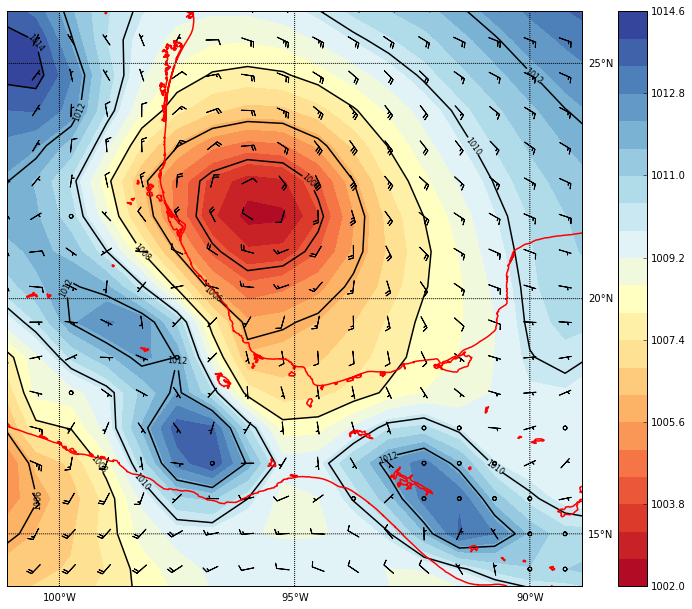

In [43]:
plt.figure(figsize=(width,height),frameon=False)
# Contour the pressure
Pf=m.contourf(x3,y3,p3,20,cmap=plt.cm.RdYlBu)

P=m.contour(x3,y3,p3,V=2,colors='k',linewidths=1.5)
plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

m.barbs(x3_th,y3_th,u3_wind_kts[::thin,::thin],\
                v3_wind_kts[::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5,color='r')
m.drawparallels(parallels,labels=[False,True,True,False])
m.drawmeridians(meridians,labels=[True,False,False,True])

plt.colorbar(Pf)
plt.title = 'Sfc Temp, MSLP (mb), 10m Wind (kts)'
plt.show()

## Analyse HWRF

In [44]:
path='/mnt/poseidon/INGRID/HWRF/TC/'

In [45]:
filename=datetime.datetime.strftime(date,'ingrid10l.%Y%m%d%H.hwrfprs.storm.0p02.f000.grb2')

In [46]:
folder=datetime.datetime.strftime(date,'%Y%m%d.%H')

In [47]:
hwrf=pygrib.open(path+folder+'/'+filename)

In [48]:
pd=hwrf[1]
ud=hwrf[706]
vd=hwrf[707]

In [49]:
p4,y4,x4 = pd.data()
u4=ud.data()[0]
v4=vd.data()[0]

In [50]:
p4 = p4 * .01

In [51]:
# flip to make lats increasing
y4 = np.flipud(y4)
p4 = np.flipud(p4)
u4 = np.flipud(u4)
v4 = np.flipud(v4)


In [52]:
u4_wind_kts, v4_wind_kts=u4 * 1.94384449, v4 * 1.94384449

In [53]:
x4 = x4 -360. # shift to the plot window

In [54]:
thin = 25

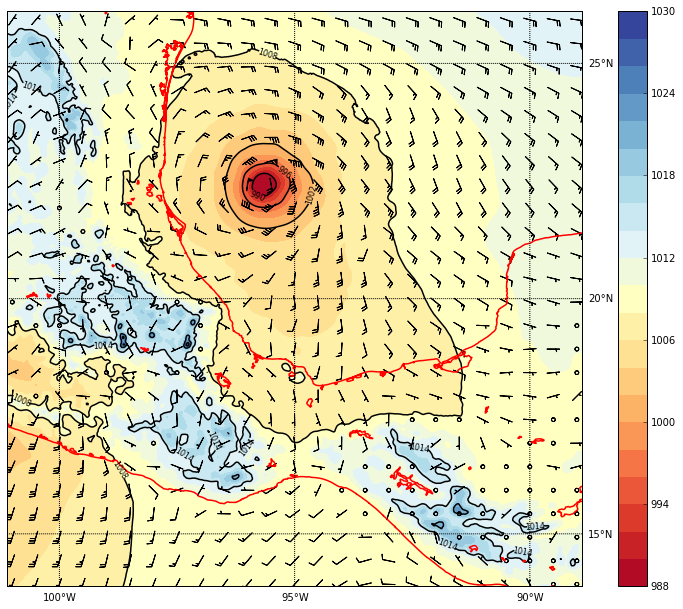

In [55]:
plt.figure(figsize=(width,height),frameon=False)
# Contour the pressure
Pf=m.contourf(x4,y4,p4,20,cmap=plt.cm.RdYlBu)

P=m.contour(x4,y4,p4,V=2,colors='k',linewidths=1.5)
plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

m.barbs(x4[::thin,::thin],y4[::thin,::thin],u4_wind_kts[::thin,::thin],\
                v4_wind_kts[::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5,color='r')
m.drawparallels(parallels,labels=[False,True,True,False])
m.drawmeridians(meridians,labels=[True,False,False,True])

plt.colorbar(Pf)
plt.title = 'Sfc Temp, MSLP (mb), 10m Wind (kts)'
plt.show()

## put all graphs together

In [58]:
pmin=min(mslp.min(),p2.min(),p3.min(), p4.min())
pmax=max(mslp.max(),p2.max(),p3.max(), p4.max())
v = np.linspace(pmin, pmax, 15, endpoint=True)

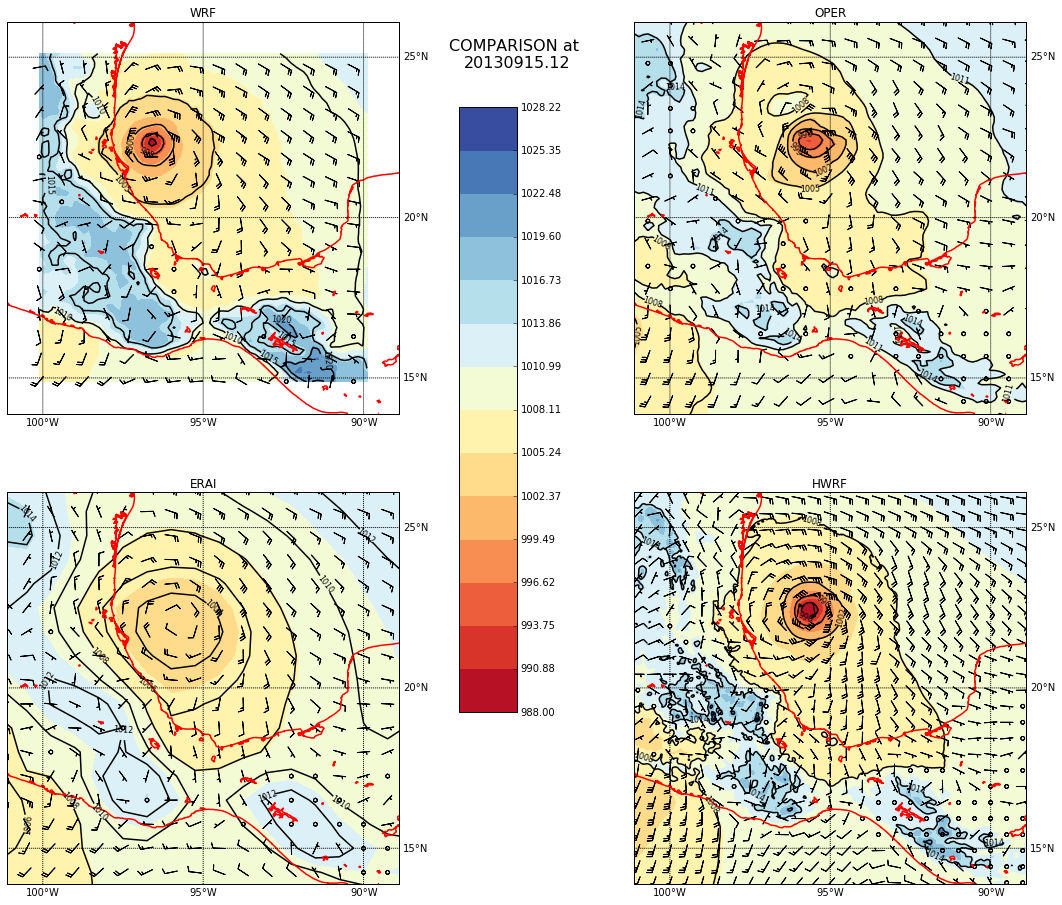

In [64]:
fig=plt.figure(figsize=(16,12))

fig.suptitle('COMPARISON at \n{}'.format(datetime.datetime.strftime(date,'%Y%m%d.%H')), fontsize=16)

plt.subplot(221)

thin=5
Pf1=m.contourf(x,y,mslp,v,cmap=plt.cm.RdYlBu)

P=m.contour(x,y,mslp,V=2,colors='k',linewidths=1.5)
plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

m.barbs(x_th,y_th,u_wind_kts[::thin,::thin],\
                v_wind_kts[::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5,color='r')
m.drawparallels(parallels,labels=[False,True,True,False])
m.drawmeridians(meridians,labels=[True,False,False,True])

ax1=fig.get_children()[1]
ax1.title.set_text('WRF')

plt.subplot(222)

# Contour the pressure
Pf2=m.contourf(x2,y2,p2[0,:,:],v,cmap=plt.cm.RdYlBu)

P=m.contour(x2,y2,p2[0,:,:],V=2,colors='k',linewidths=1.5)
plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

m.barbs(x2_th,y2_th,u2_wind_kts[::thin,::thin],\
                v2_wind_kts[::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5,color='r')
m.drawparallels(parallels,labels=[False,True,True,False])
m.drawmeridians(meridians,labels=[True,False,False,True])

ax2=fig.get_children()[2]
ax2.title.set_text('OPER')

plt.subplot(223)

thin=1
# Contour the pressure
Pf3=m.contourf(x3,y3,p3,v,cmap=plt.cm.RdYlBu)

P=m.contour(x3,y3,p3,V=2,colors='k',linewidths=1.5)
plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

m.barbs(x3_th,y3_th,u3_wind_kts[::thin,::thin],\
                v3_wind_kts[::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5,color='r')
m.drawparallels(parallels,labels=[False,True,True,False])
m.drawmeridians(meridians,labels=[True,False,False,True])

ax3=fig.get_children()[3]
ax3.title.set_text('ERAI')

plt.subplot(224)

thin = 25

P4f=m.contourf(x4,y4,p4,v,cmap=plt.cm.RdYlBu)

P=m.contour(x4,y4,p4,V=2,colors='k',linewidths=1.5)
plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

m.barbs(x4[::thin,::thin],y4[::thin,::thin],u4_wind_kts[::thin,::thin],\
                v4_wind_kts[::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5,color='r')
m.drawparallels(parallels,labels=[False,True,True,False])
m.drawmeridians(meridians,labels=[True,False,False,True])

ax4=fig.get_children()[4]
ax4.title.set_text('HWRF')

cbar_ax=fig.add_axes([0.45, 0.2, 0.05, 0.7])
fig.colorbar(Pf3,cax=cbar_ax,orientation='vertical',ticks=v)